# Example 2 of Phoeniks
> **P**ULS **h**ands-on **o**ptimized **e**xtraction *of* $\boldsymbol{n} - \boldsymbol{i}\cdot \boldsymbol{k}$'s


Load a single reference trace, sample trace, and dark trace and extract the refractive index and absorption.

# TODO: Show advantage of dark-trace, selecting automatically the right frequency range.

In [1]:
# General Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
%matplotlib notebook

home_dir = os.getcwd()
os.chdir(r"../..")
# Own library
import phoeniks as pk
os.chdir(home_dir)

# Load data
Loading reference file.

In [2]:
ref_file = "Artifical_Reference.txt"
ref = np.loadtxt(ref_file)
ref, ref.shape

(array([[ 0.00000000e+00, -1.60383681e-05],
        [ 2.44081035e-14,  6.40999140e-07],
        [ 4.88162070e-14,  7.40891296e-06],
        ...,
        [ 9.99023676e-11,  6.33831967e-06],
        [ 9.99267757e-11, -2.84087715e-05],
        [ 9.99511838e-11,  1.45666341e-05]]),
 (4096, 2))

The first column contains the signal in [s], the second column the signal in [V].
We can use the first column to derive the time-axis for the signal and save it seperately:

In [3]:
time = ref[:, 0]

Load the sample file. For this artificial sample, a thickness of 1 mm was used.

In [4]:
sample_thickness = 1e-3
sam_file = "Artifical_Sample_1mm.txt"
sam = np.loadtxt(sam_file)
sam, sam.shape

(array([[0.00000000e+00, 4.84987803e-06],
        [2.44081035e-14, 5.14138791e-07],
        [4.88162070e-14, 1.76140758e-05],
        ...,
        [9.99023676e-11, 1.25153898e-06],
        [9.99267757e-11, 1.13731580e-05],
        [9.99511838e-11, 2.80678054e-06]]),
 (4096, 2))

Load dark trace:

In [5]:
dark_file = "Artifical_Dark.txt"
dark = np.loadtxt(dark_file)

# Create data object
Feed this data into the THz data object. As a bare minimum, the following data needs to be supplied:
1. time-axis (same for reference and sample trace)
2. Signal of reference measurement in time-domain
3. Signal of sample measurement in time-domain

In [6]:
data = pk.thz_data.Data(time = time, 
                        td_reference = ref[:, 1], 
                        td_sample = sam[:, 1], 
                        td_dark = dark[:, 1])

# Plot data
To get a better view on the data, we can create a plot of reference and sample file:

<IPython.core.display.Javascript object>


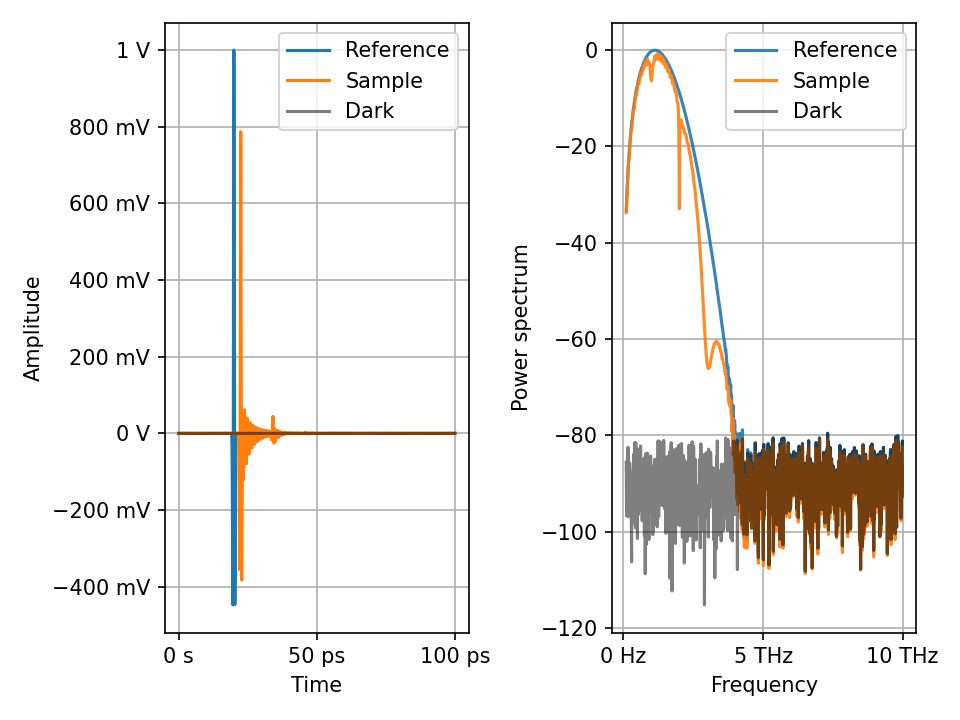

In [7]:
plot = pk.plot.Plot()
plot.plot_data(data)

## Extraction of optimal thickness

In [8]:
extract_obj = pk.extraction.Extraction(data)

In [9]:
extract_obj.unwrap_phase()

Automatic Bandwidth detection.
Frequency start: 20.0049 GHz	Frequency stop: 4.081 THz


In [10]:
extract_obj.unwrap_phase(frequency_start=0.3e12, frequency_stop=0.9e12)

<IPython.core.display.Javascript object>


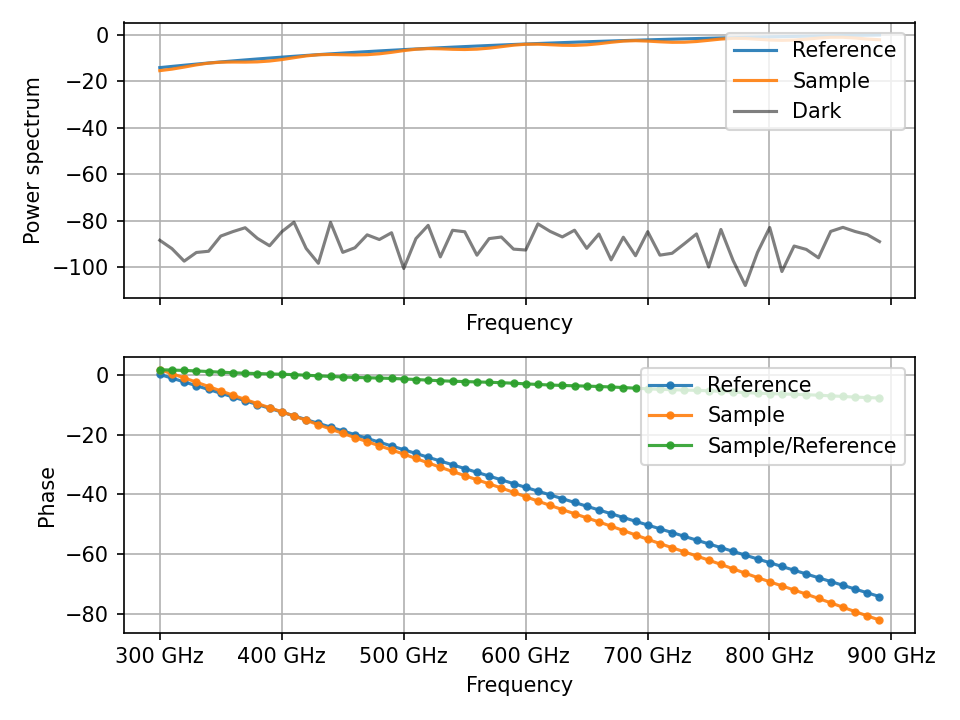

In [11]:
plot.plot_phase(extract_obj)

In [12]:
n, k = extract_obj.get_initial_nk(thickness=sample_thickness)
delta_max = extract_obj.get_max_delta(thickness=sample_thickness)

In [13]:
thickness_array, thickness_error_dict = extract_obj.get_thickness_array(thickness=1e-3,
                                                           thickness_range=50e-6,
                                                           step_size=1e-6)

  0%|          | 0/100 [00:00<?, ?it/s]

Total Variation, deg=1, optimal thickness: 1 mm
Total Variation, deg=2, optimal thickness: 1 mm
Total Variation, Nick's method, optimal thickness: 1 mm
Offset exponential, optimal thickness: 1 mm


<IPython.core.display.Javascript object>


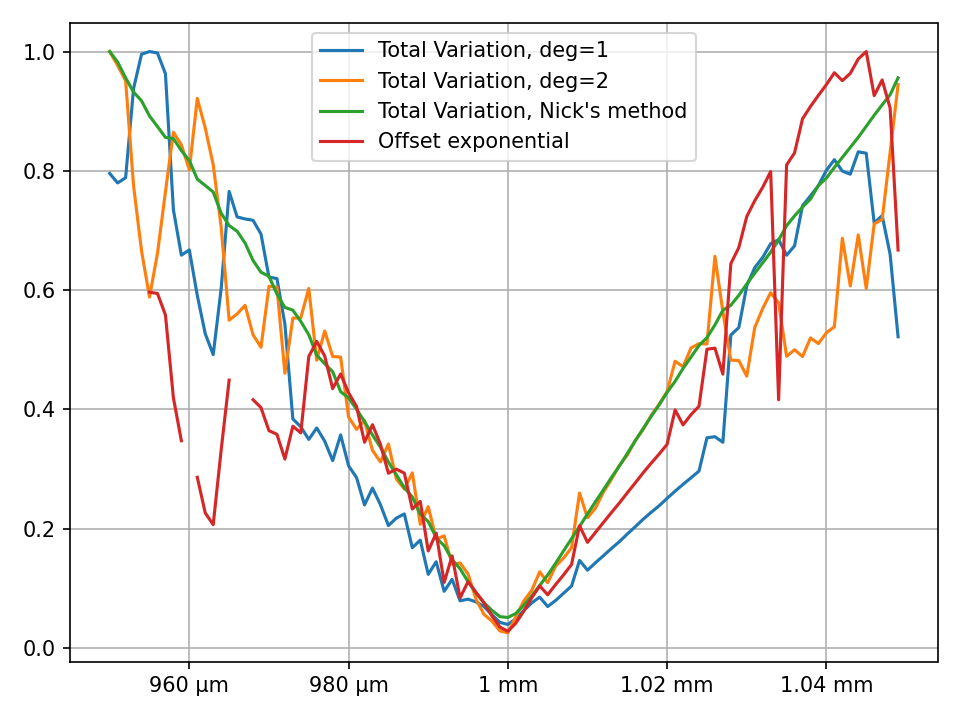

In [14]:
plot.thickness_error(thickness_array, thickness_error_dict)

# Load data for extraction
Reload the object, this time with windowing and zeroz-padding. The dark-trace cannot be zero-padded in time-domain. Instead, a linear interpolation is done in frequency domain to make it compatible to the new, higher resolution frequency axis.

<IPython.core.display.Javascript object>


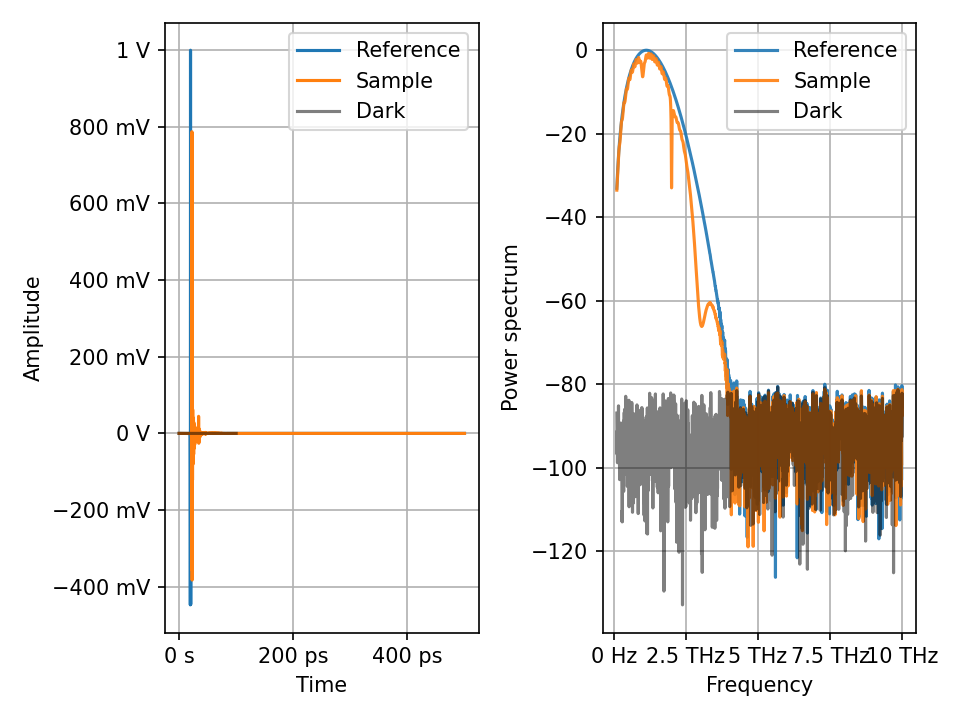

In [15]:
data = pk.thz_data.Data(time = time, 
                        td_reference = ref[:, 1], 
                        td_sample = sam[:, 1], 
                        td_dark = dark[:, 1])
data.window_traces(time_start=10e-12, time_end=90e-12)
data.pad_zeros(new_frequency_resolution=2e9)
plot = pk.plot.Plot()
plot.plot_data(data)

In [15]:
extract_obj = pk.extraction.Extraction(data)
extract_obj.unwrap_phase(frequency_start=0.3e12, frequency_stop=3.7e12)

<IPython.core.display.Javascript object>


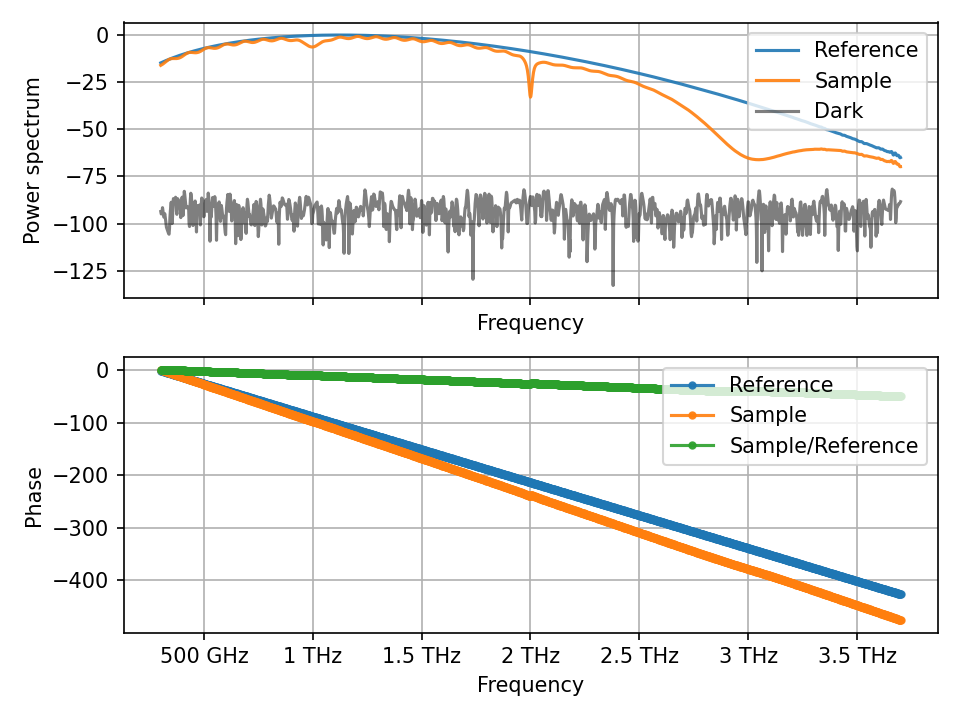

In [16]:
plot.plot_phase(extract_obj)

Getting a first guess of n and k, which is necessary for the optimization algorithm. Looking at the time-domain, we cannot only measure the time delta between the peak of reference and sample trace, but also how many echoes (Fabry-Perot reflections) would fit in the remaining time trace:

In [17]:
n, k = extract_obj.get_initial_nk(thickness=sample_thickness)
delta_max = extract_obj.get_max_delta(thickness=sample_thickness)
print(f"Δt:\t\t{EngFormatter('s', places=1)(extract_obj.get_time_shift())}")
print(f"Max. echoes:\t{delta_max}\n")

Δt:		2.5 ps
Max. echoes:	7



# Run optimization

In [30]:
frequency, n_opt, k_opt, alpha_opt = extract_obj.run_optimization(thickness=sample_thickness)

  0%|          | 0/1700 [00:00<?, ?it/s]

In [31]:
artificial_data = np.loadtxt("Artifical_n_k_alpha.txt")

<IPython.core.display.Javascript object>


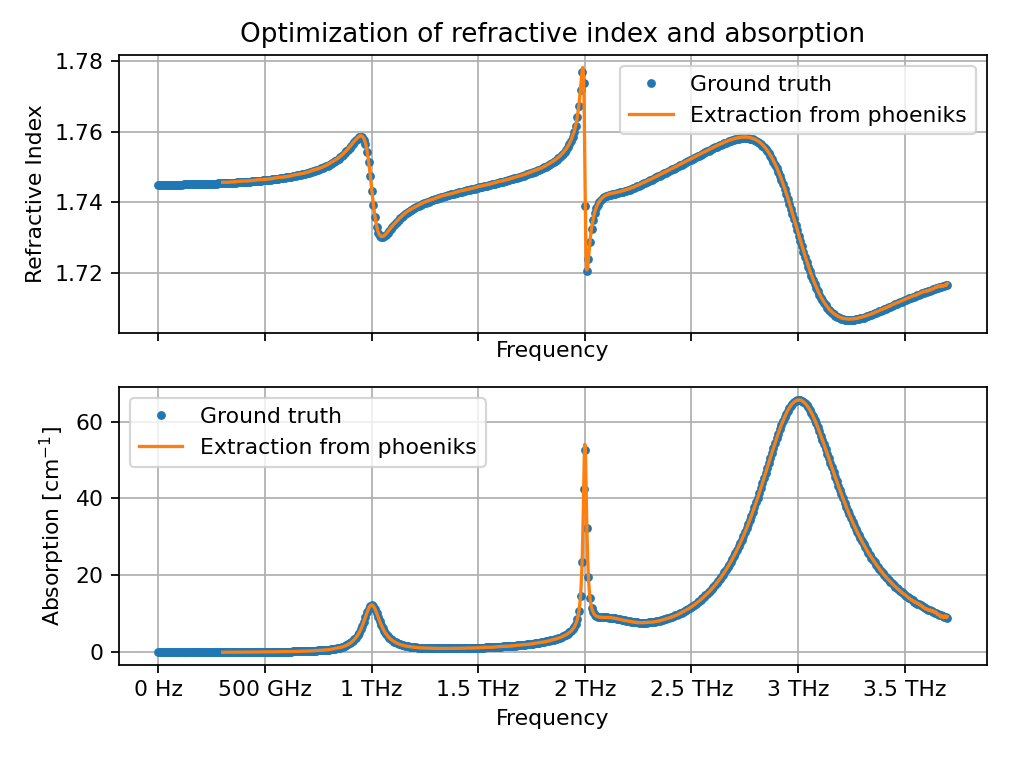

In [32]:
from scipy.constants import c as c_0
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].set_title("Optimization of refractive index and absorption")
ax[0].plot(artificial_data[:, 0], artificial_data[:, 1], ".", label="Ground truth")
ax[0].plot(frequency, n_opt, label="Extraction from phoeniks")
ax[0].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Refractive Index")
ax[0].grid(True)
ax[0].legend()

alpha = 0.01 * 4 * np.pi * k * extract_obj.data.frequency / c_0  # In [cm^-1]
ax[1].plot(artificial_data[:, 0], 0.01 * artificial_data[:, 3], ".", label="Ground truth")
ax[1].plot(frequency, 0.01 * alpha_opt, label="Extraction from phoeniks")
ax[1].xaxis.set_major_formatter(EngFormatter("Hz"))
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel(r"Absorption [$\mathrm{cm}^{-1}$]")
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()